## ℹ️ Info

| Method | LB |
| --- | :---: |
| LGBM 5 fold | 0.801 |
| LGBM 15 fold | 0.802 |
| LGBM 15 fold + post-processing | 0.803 |
| LGBM 15 fold + 5 fold Deberta (Ensemble) | 0.807 |
| LGBM 16 fold + 5 fold Deberta (Ensemble) | 0.808 |
| LGBM 15 fold + 5 fold Deberta (Ensemble) + CountVectorizer | 0.810 |
| LGBM 15 fold + 5 fold Deberta (as features) + CountVectorizer | 0.811 |
| LGBM 16 fold + 5 fold Deberta (as features) + CountVectorizer + HashingVectorizer | 0.811 |
| LGBM 15 fold + 5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer | 0.812 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer(ngram(3,5)) | 0.816 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer(ngram(3,4)) | 0.817 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + more feature engineering + feature selection | 0.818 |


* 2024/04/15 : forked original great work kernels
    * https://www.kaggle.com/code/olyatsimboy/5-fold-deberta-lgbm
    * https://www.kaggle.com/code/aikhmelnytskyy/quick-start-lgbm
    * https://www.kaggle.com/code/hideyukizushi/aes2-5folddeberta-lgbm-countvectorizer-lb-810
    * https://www.kaggle.com/code/olyatsimboy/81-1-aes2-5folddeberta-lgbm-stacking  
    
    
* 2024/04/16 : ~~add HashingVectorizer~~ (not work)
* 2024/04/21 : Add MetaFEs. Train deberta-v3-large local (5Fold SKF) 
    * https://www.kaggle.com/datasets/hideyukizushi/aes2-400-20240419134941    
* 2024/04/22 : change TfidfVectorizer ngram to (3,6), CountVectorizer ngram to (3,5)
* 2024/04/23 : change CountVectorizer ngram to (3,4)
* 2024/04/24 : MORE FEATURE ENGINEERING + FEATURE SELECTION
    * https://www.kaggle.com/code/xianhellg/more-feature-engineering-feature-selection-0-817
---

# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ 5 Fold Deberta ◀️</div>

In [1]:
import pandas as pd 
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding
)
from datasets import Dataset
from glob import glob
import gc
import torch
from scipy.special import softmax

MAX_LENGTH = 1024
TEST_DATA_PATH = "kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = 'kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1

# Deberta Model

In [2]:
models = glob(MODEL_PATH)
# print(models)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )
    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))  
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
predicted_score = 0.

for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [3]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head() 

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4


In [4]:
df_test[['essay_id', 'score']].to_csv('submission_1.csv', index=False)

# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ 15 fold LGBM ◀️</div>

In [5]:
# Importing necessary libraries
import gc
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import spacy
import string
import torch
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import DMatrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import joblib

In [6]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

nlp = spacy.load("en_core_web_sm")
with open('kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)

# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people have car where the…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


# Features engineering

In [7]:
def count_spelling_errors(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

## Paragraph Features

In [8]:
# paragraph features
def remove_punctuation(text):
    """
    Remove all punctuation from the input text.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The text with punctuation removed.
    """
    # string.punctuation
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def Paragraph_Preprocess(tmp):
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  
        ]
    
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


In [9]:
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

/tmp/ipykernel_2460041/1122620497.py:20: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
/tmp/ipykernel_2460041/1122620497.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
/tmp/ipykernel_2460041/1122620497.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
thread '<unnamed>' panicked at py-polars/src/map/s

PanicException: python function failed KeyboardInterrupt: 

PanicException: python function failed KeyboardInterrupt: 

## Sentence Feature

In [ ]:
# sentence feature
def Sentence_Preprocess(tmp):
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp
# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_lessthan{i}_cnt") for i in [15,50] ], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea], 
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea], 
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df



In [ ]:
tmp = Sentence_Preprocess(train)
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Word Feature

In [ ]:
# word feature
def Word_Preprocess(tmp):
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df



In [ ]:
tmp = Word_Preprocess(train)
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Vectorizer

In [ ]:
# TfidfVectorizer parameter
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)
# Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])

In [ ]:

# Convert to array
dense_matrix = train_tfid.toarray()
# Convert to dataframe
df = pd.DataFrame(dense_matrix)
# rename features
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

In [ ]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])


In [ ]:
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

NameError: name 'train_tfid' is not defined

## Deberta predictions to LGBM as features

In [16]:
# add Deberta predictions to LGBM as features
deberta_oof = joblib.load('kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ', len(feature_names))
train_feats.to_csv('kaggle/input/train_feats.csv',index=False) # save train_feats data
train_feats.to_pickle('kaggle/input/train_feats.pkl')
train_feats.shape

NameError: name 'train_feats' is not defined

In [8]:
train_feats = pd.read_pickle('kaggle/input/train_feats.pkl')
train_feats_argument = pd.read_pickle('kaggle/input/argument-feat.pkl')
for i in range(2):
    train_feats[f'argument_{i}'] = train_feats_argument.iloc[:, i]
# train_feats = pd.read_csv('kaggle/input/train_feats.csv') # load train_feats data
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ', len(feature_names))
train_feats.shape

Features Number:  21907


(17307, 21909)

In [9]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + a).round()
        y_pred = (y_pred + a).clip(1, 6).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk
    else:
        # For lgb
        y_true = y_true + a
        y_pred = (y_pred + a).clip(1, 6).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True
    

def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.998
b = 1.092

In [10]:
# Converting the 'text' column to string type and assigning to X
X = train_feats[feature_names].astype(np.float32).values

# Converting the 'score' column to integer type and assigning to y
y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a

# Feature Selection

In [11]:

def feature_select_wrapper(LOAD):
    """
    lgm
    :param train
    :param test
    :return
    """
    # Part 1.
    print('feature_select_wrapper...')
    features = feature_names
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    fse = pd.Series(0, index=features)
    models = []
    i=1
    for train_index, test_index in skf.split(X, y_split):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.05,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=412,
                    extra_trees=True,
                    class_weight='balanced',
                    verbosity = - 1)

        predictor = model.fit(X_train_fold,
                            y_train_fold,
                            eval_names=['train', 'valid'],
                            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                            eval_metric=quadratic_weighted_kappa,
                            callbacks=callbacks)
        models.append(predictor)
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')
        fse += pd.Series(predictor.feature_importances_, features)
        predictor.booster_.save_model(f'kaggle/out/aes-feat-select-lgbm/fold_{i}.txt')
        print('\nFold_{} LightGBM Selection Model saved.\n'.format(i))
        i+=1
    
    # Part 4.
    feature_select = fse.sort_values(ascending=False).index.tolist()[:15000] # 不要按照他的这个来，要具体根据confusion matrix来选，不一定选前13000个。
    print('done')
    return feature_select

feature_select_wrapper...
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK: 0.860981	valid's QWK: 0.834253
Early stopping, best iteration is:
[355]	train's QWK: 0.866516	valid's QWK: 0.836075
Evaluated only: QWK


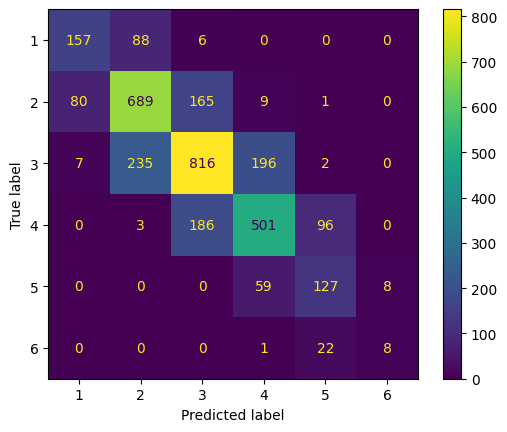

F1 score across fold: 0.6633811113351648
Cohen kappa score across fold: 0.836075034334251

Fold_1 LightGBM Selection Model saved.

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[300]	train's QWK: 0.860201	valid's QWK: 0.829516
Early stopping, best iteration is:
[402]	train's QWK: 0.868234	valid's QWK: 0.831782
Evaluated only: QWK


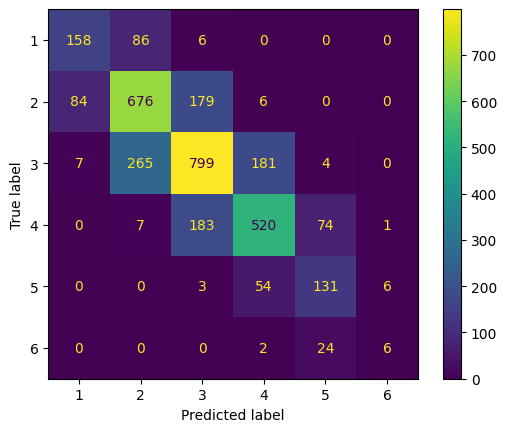

F1 score across fold: 0.6603691662788873
Cohen kappa score across fold: 0.8317816441194182

Fold_2 LightGBM Selection Model saved.

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK: 0.860472	valid's QWK: 0.82903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[268]	train's QWK: 0.857119	valid's QWK: 0.829813
Evaluated only: QWK


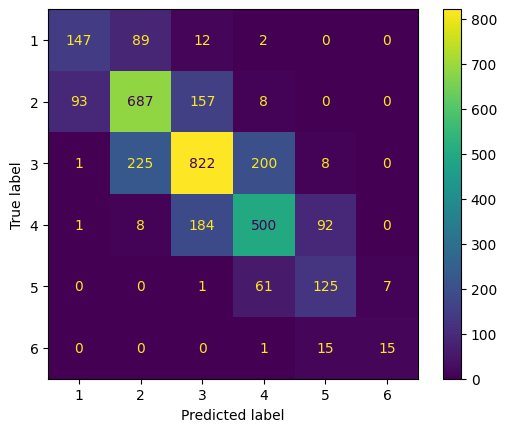

F1 score across fold: 0.663508003203023
Cohen kappa score across fold: 0.8298127040852864

Fold_3 LightGBM Selection Model saved.

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[182]	train's QWK: 0.848683	valid's QWK: 0.830467
Evaluated only: QWK


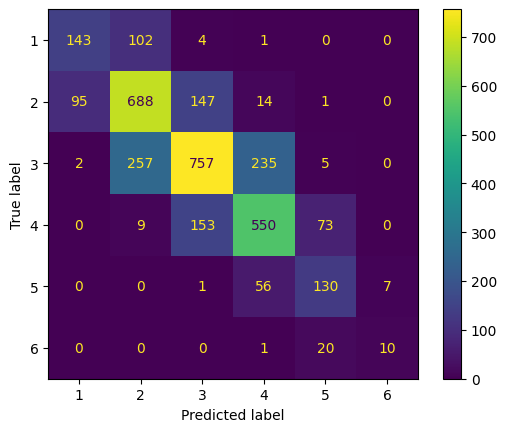

F1 score across fold: 0.6570795040678872
Cohen kappa score across fold: 0.8304670435484035

Fold_4 LightGBM Selection Model saved.

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[300]	train's QWK: 0.858139	valid's QWK: 0.838061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[308]	train's QWK: 0.858668	valid's QWK: 0.839318
Evaluated only: QWK


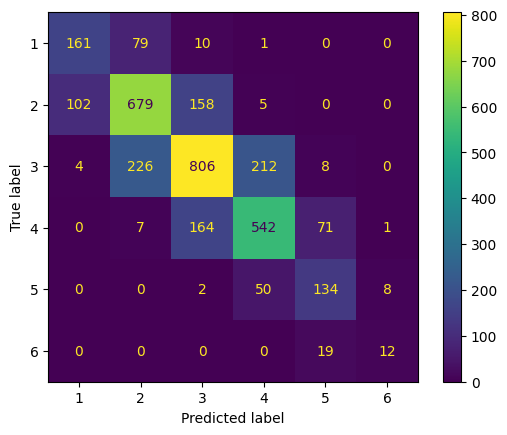

F1 score across fold: 0.6742027062305691
Cohen kappa score across fold: 0.839317964505282

Fold_5 LightGBM Selection Model saved.

done


In [12]:
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=75,first_metric_only=True)]
feature_select = feature_select_wrapper(LOAD=True)

In [13]:
X = train_feats[feature_select].astype(np.float32).values
print('Features Select Number: ', len(feature_select)) 

Features Select Number:  15000


# Model training

In [16]:
from xgboost import DMatrix


class Predictor:
    def __init__(self, models: list):
        self.models = models
    def predict(self, X):
        n_models = len(self.models)
        predicted = None
        for i, model in enumerate(self.models):
            if i == 0: # LightGBM weight
                predicted = 0.76*model.predict(X)
            elif i == 1: # CatBoost weight
                predicted += 0*model.predict(X)
            else: # XGBoost weight
                # if not isinstance(X, DMatrix):
                #     X = xgb.DMatrix(X)
                predicted += 0.24*model.predict(X)
                    
        return predicted

Running on GPU

Fold_1 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.84803	valid's QWK: 0.820509
Early stopping, best iteration is:
[132]	train's QWK: 0.838721	valid's QWK: 0.822316
Evaluated only: QWK

Fold_1 LightGBM Model saved.

0:	learn: 0.9729678	test: 0.9741978	best: 0.9741978 (0)	total: 132ms	remaining: 2m 12s
100:	learn: 0.5098883	test: 0.5326149	best: 0.5324217 (99)	total: 11.9s	remaining: 1m 45s
200:	learn: 0.4894438	test: 0.5323965	best: 0.5316056 (171)	total: 22.8s	remaining: 1m 30s
bestTest = 0.5316056462
bestIteration = 171
Shrink model to first 172 iterations.

Fold_1 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:13:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:13:21] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07944	validation_0-QWK:0.46826	validation_1-rmse:1.08976	validation_1-QWK:0.42705
[0]	validation_0-rmse:1.07944	validation_0-QWK:0.46826	validation_1-rmse:1.08976	validation_1-QWK:0.42705
[1]	validation_0-rmse:0.97688	validation_0-QWK:0.46906	validation_1-rmse:0.99430	validation_1-QWK:0.44304
[2]	validation_0-rmse:0.88229	validation_0-QWK:0.48540	validation_1-rmse:0.90928	validation_1-QWK:0.44391
[3]	validation_0-rmse:0.80053	validation_0-QWK:0.53860	validation_1-rmse:0.83597	validation_1-QWK:0.50417
[4]	validation_0-rmse:0.73113	validation_0-QWK:0.62861	validation_1-rmse:0.77603	validation_1-QWK:0.58791
[5]	validation_0-rmse:0.67350	validation_0-QWK:0.68007	validation_1-rmse:0.72678	validation_1-QWK:0.62621
[6]	validation_0-rmse:0.62793	validation_0-QWK:0.71537	validation_1-rmse:0.69154	validation_1-QWK:0.66058
[7]	validation_0-rmse:0.58886	validation_0-QWK:0.75977	validation_1-rmse:0.65904	validation_1-QWK:0.71093
[8]	validation_0-rmse:0.55646	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:13:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:13:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:13:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cu

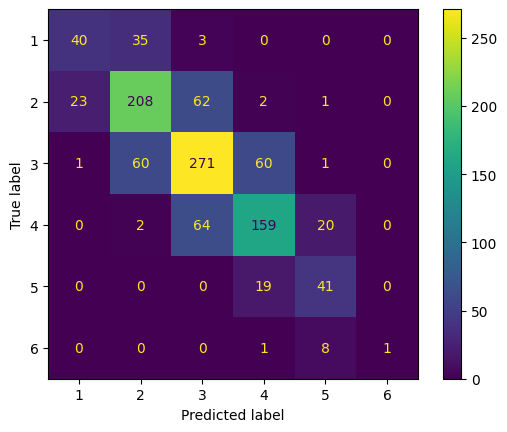

F1 score across fold: 0.6627733340411917
Cohen kappa score across fold: 0.824024838194742

Fold_2 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.848924	valid's QWK: 0.837717
Early stopping, best iteration is:
[191]	train's QWK: 0.847868	valid's QWK: 0.839128
Evaluated only: QWK

Fold_2 LightGBM Model saved.

0:	learn: 0.9727722	test: 0.9735693	best: 0.9735693 (0)	total: 144ms	remaining: 2m 24s
100:	learn: 0.5114664	test: 0.5081013	best: 0.5080885 (99)	total: 11.9s	remaining: 1m 45s
200:	learn: 0.4931049	test: 0.5078182	best: 0.5072822 (177)	total: 22.8s	remaining: 1m 30s
bestTest = 0.5072822439
bestIteration = 177
Shrink model to first 178 iterations.

Fold_2 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07996	validation_0-QWK:0.46048	validation_1-rmse:1.08638	validation_1-QWK:0.45450
[0]	validation_0-rmse:1.07996	validation_0-QWK:0.46048	validation_1-rmse:1.08638	validation_1-QWK:0.45450
[1]	validation_0-rmse:0.97693	validation_0-QWK:0.46716	validation_1-rmse:0.98735	validation_1-QWK:0.46299
[2]	validation_0-rmse:0.88235	validation_0-QWK:0.48523	validation_1-rmse:0.89867	validation_1-QWK:0.47532
[3]	validation_0-rmse:0.80042	validation_0-QWK:0.54463	validation_1-rmse:0.82212	validation_1-QWK:0.53094
[4]	validation_0-rmse:0.73115	validation_0-QWK:0.62509	validation_1-rmse:0.75858	validation_1-QWK:0.59779
[5]	validation_0-rmse:0.67383	validation_0-QWK:0.68088	validation_1-rmse:0.70777	validation_1-QWK:0.64368
[6]	validation_0-rmse:0.62862	validation_0-QWK:0.71150	validation_1-rmse:0.66846	validation_1-QWK:0.67893
[7]	validation_0-rmse:0.58945	validation_0-QWK:0.76294	validation_1-rmse:0.63553	validation_1-QWK:0.72645
[8]	validation_0-rmse:0.55750	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:15:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


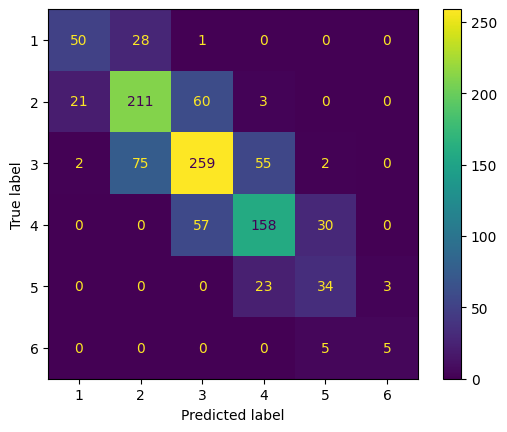

F1 score across fold: 0.6630608604228163
Cohen kappa score across fold: 0.8366303698948203

Fold_3 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.848345	valid's QWK: 0.837919
[400]	train's QWK: 0.864529	valid's QWK: 0.840556
Early stopping, best iteration is:
[333]	train's QWK: 0.859667	valid's QWK: 0.843658
Evaluated only: QWK

Fold_3 LightGBM Model saved.

0:	learn: 0.9730072	test: 0.9708930	best: 0.9708930 (0)	total: 132ms	remaining: 2m 11s
100:	learn: 0.5092281	test: 0.5275330	best: 0.5268930 (84)	total: 12s	remaining: 1m 46s
200:	learn: 0.4864037	test: 0.5269928	best: 0.5262466 (129)	total: 23.4s	remaining: 1m 33s
bestTest = 0.5262465748
bestIteration = 129
Shrink model to first 130 iterations.

Fold_3 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:05] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07996	validation_0-QWK:0.46014	validation_1-rmse:1.08947	validation_1-QWK:0.46036
[0]	validation_0-rmse:1.07996	validation_0-QWK:0.46014	validation_1-rmse:1.08947	validation_1-QWK:0.46036
[1]	validation_0-rmse:0.97720	validation_0-QWK:0.46812	validation_1-rmse:0.99293	validation_1-QWK:0.45711
[2]	validation_0-rmse:0.88294	validation_0-QWK:0.48596	validation_1-rmse:0.90665	validation_1-QWK:0.45883
[3]	validation_0-rmse:0.80096	validation_0-QWK:0.56427	validation_1-rmse:0.83276	validation_1-QWK:0.51421
[4]	validation_0-rmse:0.73161	validation_0-QWK:0.62790	validation_1-rmse:0.77142	validation_1-QWK:0.60088
[5]	validation_0-rmse:0.67424	validation_0-QWK:0.67396	validation_1-rmse:0.72276	validation_1-QWK:0.62844
[6]	validation_0-rmse:0.62928	validation_0-QWK:0.70983	validation_1-rmse:0.68773	validation_1-QWK:0.65750
[7]	validation_0-rmse:0.59083	validation_0-QWK:0.76254	validation_1-rmse:0.65641	validation_1-QWK:0.71837
[8]	validation_0-rmse:0.55913	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:17:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


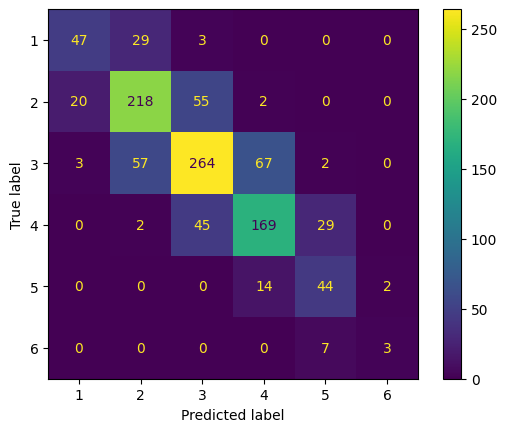

F1 score across fold: 0.6882470474901465
Cohen kappa score across fold: 0.8442843506517057

Fold_4 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847121	valid's QWK: 0.827047
Early stopping, best iteration is:
[320]	train's QWK: 0.858068	valid's QWK: 0.833482
Evaluated only: QWK

Fold_4 LightGBM Model saved.

0:	learn: 0.9721817	test: 0.9754667	best: 0.9754667 (0)	total: 139ms	remaining: 2m 18s
100:	learn: 0.5099214	test: 0.5331091	best: 0.5328789 (99)	total: 11.8s	remaining: 1m 44s
bestTest = 0.5324708135
bestIteration = 115
Shrink model to first 116 iterations.

Fold_4 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:05] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07959	validation_0-QWK:0.46021	validation_1-rmse:1.08550	validation_1-QWK:0.42858
[0]	validation_0-rmse:1.07959	validation_0-QWK:0.46021	validation_1-rmse:1.08550	validation_1-QWK:0.42858
[1]	validation_0-rmse:0.97663	validation_0-QWK:0.46722	validation_1-rmse:0.98854	validation_1-QWK:0.43969
[2]	validation_0-rmse:0.88207	validation_0-QWK:0.48471	validation_1-rmse:0.90366	validation_1-QWK:0.46217
[3]	validation_0-rmse:0.79998	validation_0-QWK:0.54660	validation_1-rmse:0.83096	validation_1-QWK:0.51223
[4]	validation_0-rmse:0.73089	validation_0-QWK:0.62954	validation_1-rmse:0.76989	validation_1-QWK:0.58826
[5]	validation_0-rmse:0.67340	validation_0-QWK:0.68016	validation_1-rmse:0.72079	validation_1-QWK:0.64984
[6]	validation_0-rmse:0.62815	validation_0-QWK:0.71662	validation_1-rmse:0.68575	validation_1-QWK:0.67716
[7]	validation_0-rmse:0.58919	validation_0-QWK:0.76122	validation_1-rmse:0.65492	validation_1-QWK:0.71984
[8]	validation_0-rmse:0.55712	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:19:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not


Fold_4 XGBoost Model saved.



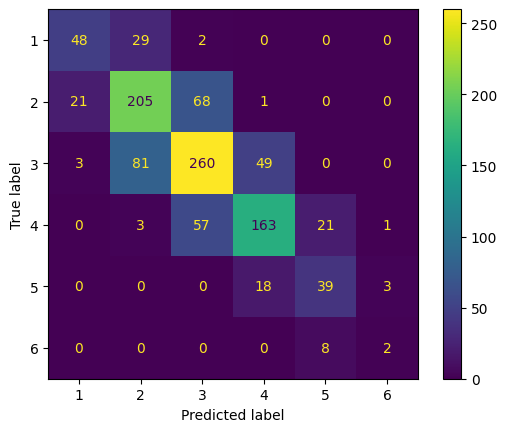

F1 score across fold: 0.6620980618751953
Cohen kappa score across fold: 0.8312503010637718

Fold_5 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.846927	valid's QWK: 0.837478
[400]	train's QWK: 0.863613	valid's QWK: 0.843318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[460]	train's QWK: 0.868327	valid's QWK: 0.846533
Evaluated only: QWK

Fold_5 LightGBM Model saved.

0:	learn: 0.9727603	test: 0.9721000	best: 0.9721000 (0)	total: 131ms	remaining: 2m 11s
100:	learn: 0.5099487	test: 0.5213991	best: 0.5213878 (99)	total: 11.8s	remaining: 1m 45s
bestTest = 0.520714622
bestIteration = 115
Shrink model to first 116 iterations.

Fold_5 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:15] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07927	validation_0-QWK:0.45710	validation_1-rmse:1.08178	validation_1-QWK:0.45193
[0]	validation_0-rmse:1.07927	validation_0-QWK:0.45710	validation_1-rmse:1.08178	validation_1-QWK:0.45193
[1]	validation_0-rmse:0.97683	validation_0-QWK:0.46858	validation_1-rmse:0.98076	validation_1-QWK:0.46041
[2]	validation_0-rmse:0.88233	validation_0-QWK:0.49474	validation_1-rmse:0.89017	validation_1-QWK:0.48030
[3]	validation_0-rmse:0.80023	validation_0-QWK:0.54406	validation_1-rmse:0.81285	validation_1-QWK:0.53100
[4]	validation_0-rmse:0.73098	validation_0-QWK:0.62733	validation_1-rmse:0.74906	validation_1-QWK:0.61741
[5]	validation_0-rmse:0.67372	validation_0-QWK:0.68192	validation_1-rmse:0.69801	validation_1-QWK:0.66109
[6]	validation_0-rmse:0.62898	validation_0-QWK:0.71271	validation_1-rmse:0.66098	validation_1-QWK:0.68877
[7]	validation_0-rmse:0.58998	validation_0-QWK:0.75988	validation_1-rmse:0.63007	validation_1-QWK:0.73217
[8]	validation_0-rmse:0.55823	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_5 XGBoost Model saved.



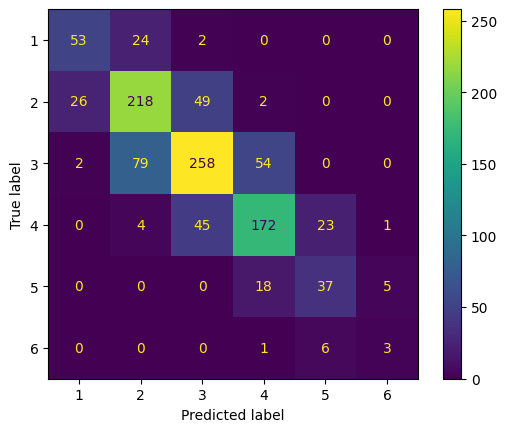

F1 score across fold: 0.6848020290243674
Cohen kappa score across fold: 0.8441063999406868

Fold_6 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847809	valid's QWK: 0.822131
Early stopping, best iteration is:
[158]	train's QWK: 0.843372	valid's QWK: 0.825263
Evaluated only: QWK

Fold_6 LightGBM Model saved.

0:	learn: 0.9728032	test: 0.9747895	best: 0.9747895 (0)	total: 141ms	remaining: 2m 21s
100:	learn: 0.5090550	test: 0.5322235	best: 0.5322177 (91)	total: 11.8s	remaining: 1m 44s
200:	learn: 0.4855428	test: 0.5322490	best: 0.5303732 (128)	total: 23s	remaining: 1m 31s
bestTest = 0.5303731627
bestIteration = 128
Shrink model to first 129 iterations.

Fold_6 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:23:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:23:06] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07955	validation_0-QWK:0.45553	validation_1-rmse:1.08737	validation_1-QWK:0.43908
[0]	validation_0-rmse:1.07955	validation_0-QWK:0.45553	validation_1-rmse:1.08737	validation_1-QWK:0.43908
[1]	validation_0-rmse:0.97665	validation_0-QWK:0.46531	validation_1-rmse:0.99456	validation_1-QWK:0.45227
[2]	validation_0-rmse:0.88241	validation_0-QWK:0.48327	validation_1-rmse:0.91051	validation_1-QWK:0.45803
[3]	validation_0-rmse:0.80038	validation_0-QWK:0.53096	validation_1-rmse:0.83805	validation_1-QWK:0.50141
[4]	validation_0-rmse:0.73085	validation_0-QWK:0.62718	validation_1-rmse:0.77809	validation_1-QWK:0.58939
[5]	validation_0-rmse:0.67354	validation_0-QWK:0.67919	validation_1-rmse:0.73016	validation_1-QWK:0.64035
[6]	validation_0-rmse:0.62800	validation_0-QWK:0.71747	validation_1-rmse:0.69463	validation_1-QWK:0.66612
[7]	validation_0-rmse:0.58890	validation_0-QWK:0.75919	validation_1-rmse:0.66360	validation_1-QWK:0.70847
[8]	validation_0-rmse:0.55715	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:23:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:23:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_6 XGBoost Model saved.



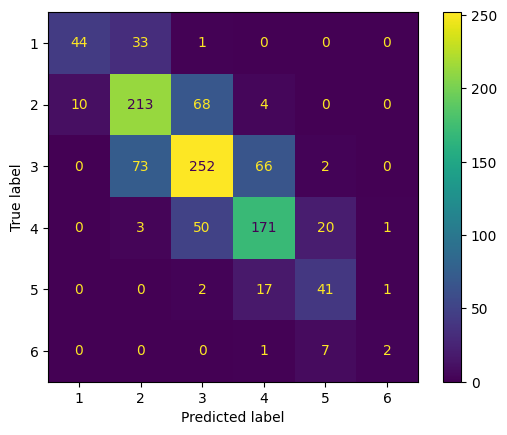

F1 score across fold: 0.6668660589752874
Cohen kappa score across fold: 0.825432333413533

Fold_7 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's QWK: 0.84794	valid's QWK: 0.825878
Early stopping, best iteration is:
[136]	train's QWK: 0.841402	valid's QWK: 0.829301
Evaluated only: QWK

Fold_7 LightGBM Model saved.

0:	learn: 0.9724890	test: 0.9741382	best: 0.9741382 (0)	total: 128ms	remaining: 2m 8s
100:	learn: 0.5099849	test: 0.5402093	best: 0.5402006 (75)	total: 11.6s	remaining: 1m 43s
200:	learn: 0.4891039	test: 0.5371969	best: 0.5368844 (190)	total: 22.5s	remaining: 1m 29s
300:	learn: 0.4710876	test: 0.5363014	best: 0.5357118 (265)	total: 33.5s	remaining: 1m 17s
400:	learn: 0.4536567	test: 0.5353042	best: 0.5345504 (362)	total: 44.4s	remaining: 1m 6s
bestTest = 0.5345503663
bestIterat

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:25:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:25:17] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07955	validation_0-QWK:0.46147	validation_1-rmse:1.08576	validation_1-QWK:0.43505
[0]	validation_0-rmse:1.07955	validation_0-QWK:0.46147	validation_1-rmse:1.08576	validation_1-QWK:0.43505
[1]	validation_0-rmse:0.97675	validation_0-QWK:0.46657	validation_1-rmse:0.99045	validation_1-QWK:0.44833
[2]	validation_0-rmse:0.88223	validation_0-QWK:0.49452	validation_1-rmse:0.90482	validation_1-QWK:0.47916
[3]	validation_0-rmse:0.79998	validation_0-QWK:0.52350	validation_1-rmse:0.83248	validation_1-QWK:0.50181
[4]	validation_0-rmse:0.73057	validation_0-QWK:0.62393	validation_1-rmse:0.77421	validation_1-QWK:0.59193
[5]	validation_0-rmse:0.67327	validation_0-QWK:0.67710	validation_1-rmse:0.72622	validation_1-QWK:0.65435
[6]	validation_0-rmse:0.62815	validation_0-QWK:0.71408	validation_1-rmse:0.69055	validation_1-QWK:0.68856
[7]	validation_0-rmse:0.58967	validation_0-QWK:0.75914	validation_1-rmse:0.65985	validation_1-QWK:0.72435
[8]	validation_0-rmse:0.55763	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:26:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


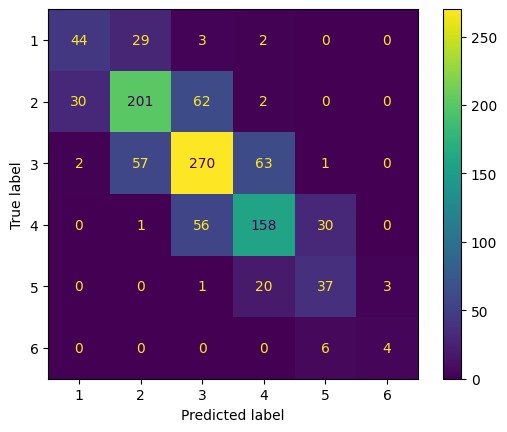

F1 score across fold: 0.6603250241032803
Cohen kappa score across fold: 0.8260069077061475

Fold_8 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847837	valid's QWK: 0.827169
Early stopping, best iteration is:
[227]	train's QWK: 0.850853	valid's QWK: 0.829014
Evaluated only: QWK

Fold_8 LightGBM Model saved.

0:	learn: 0.9726744	test: 0.9741213	best: 0.9741213 (0)	total: 130ms	remaining: 2m 9s
100:	learn: 0.5099847	test: 0.5390149	best: 0.5390149 (100)	total: 11.5s	remaining: 1m 42s
bestTest = 0.5390149111
bestIteration = 100
Shrink model to first 101 iterations.

Fold_8 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:27:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:27:20] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07991	validation_0-QWK:0.46047	validation_1-rmse:1.08659	validation_1-QWK:0.43842
[0]	validation_0-rmse:1.07991	validation_0-QWK:0.46047	validation_1-rmse:1.08659	validation_1-QWK:0.43842
[1]	validation_0-rmse:0.97696	validation_0-QWK:0.46818	validation_1-rmse:0.99120	validation_1-QWK:0.44695
[2]	validation_0-rmse:0.88264	validation_0-QWK:0.49060	validation_1-rmse:0.90566	validation_1-QWK:0.46176
[3]	validation_0-rmse:0.80070	validation_0-QWK:0.54384	validation_1-rmse:0.83125	validation_1-QWK:0.52107
[4]	validation_0-rmse:0.73132	validation_0-QWK:0.63114	validation_1-rmse:0.77205	validation_1-QWK:0.58299
[5]	validation_0-rmse:0.67354	validation_0-QWK:0.68075	validation_1-rmse:0.72445	validation_1-QWK:0.63324
[6]	validation_0-rmse:0.62831	validation_0-QWK:0.71129	validation_1-rmse:0.68712	validation_1-QWK:0.66164
[7]	validation_0-rmse:0.58936	validation_0-QWK:0.76070	validation_1-rmse:0.65663	validation_1-QWK:0.71063
[8]	validation_0-rmse:0.55784	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:27:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:27:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


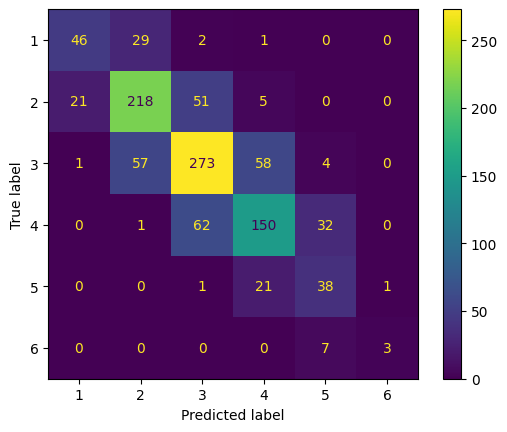

F1 score across fold: 0.672802562518643
Cohen kappa score across fold: 0.8284359668746811

Fold_9 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847454	valid's QWK: 0.837883
Early stopping, best iteration is:
[238]	train's QWK: 0.849939	valid's QWK: 0.841488
Evaluated only: QWK

Fold_9 LightGBM Model saved.

0:	learn: 0.9729073	test: 0.9759027	best: 0.9759027 (0)	total: 129ms	remaining: 2m 8s
100:	learn: 0.5087895	test: 0.5306871	best: 0.5304707 (96)	total: 11.8s	remaining: 1m 45s
200:	learn: 0.4889451	test: 0.5300365	best: 0.5299060 (197)	total: 22.7s	remaining: 1m 30s
300:	learn: 0.4711545	test: 0.5318424	best: 0.5296508 (227)	total: 33.7s	remaining: 1m 18s
bestTest = 0.5296508439
bestIteration = 227
Shrink model to first 228 iterations.

Fold_9 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:22] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07968	validation_0-QWK:0.46070	validation_1-rmse:1.08958	validation_1-QWK:0.44530
[0]	validation_0-rmse:1.07968	validation_0-QWK:0.46070	validation_1-rmse:1.08958	validation_1-QWK:0.44530
[1]	validation_0-rmse:0.97658	validation_0-QWK:0.46831	validation_1-rmse:0.99313	validation_1-QWK:0.44617
[2]	validation_0-rmse:0.88236	validation_0-QWK:0.48241	validation_1-rmse:0.90796	validation_1-QWK:0.45287
[3]	validation_0-rmse:0.79994	validation_0-QWK:0.53938	validation_1-rmse:0.83361	validation_1-QWK:0.50379
[4]	validation_0-rmse:0.73093	validation_0-QWK:0.62919	validation_1-rmse:0.77284	validation_1-QWK:0.58700
[5]	validation_0-rmse:0.67388	validation_0-QWK:0.67670	validation_1-rmse:0.72469	validation_1-QWK:0.64579
[6]	validation_0-rmse:0.62875	validation_0-QWK:0.71429	validation_1-rmse:0.68745	validation_1-QWK:0.68294
[7]	validation_0-rmse:0.58977	validation_0-QWK:0.75873	validation_1-rmse:0.65563	validation_1-QWK:0.72240
[8]	validation_0-rmse:0.55780	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:29:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_9 XGBoost Model saved.



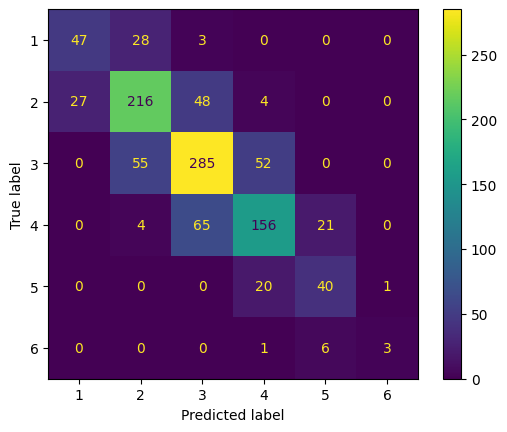

F1 score across fold: 0.6892395493625982
Cohen kappa score across fold: 0.8398063095455681

Fold_10 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847297	valid's QWK: 0.834407
Early stopping, best iteration is:
[299]	train's QWK: 0.856629	valid's QWK: 0.836512
Evaluated only: QWK

Fold_10 LightGBM Model saved.

0:	learn: 0.9720400	test: 0.9723009	best: 0.9723009 (0)	total: 135ms	remaining: 2m 14s
100:	learn: 0.5101066	test: 0.5386108	best: 0.5386108 (100)	total: 11.7s	remaining: 1m 44s
200:	learn: 0.4915153	test: 0.5384691	best: 0.5376028 (135)	total: 22.4s	remaining: 1m 29s
bestTest = 0.537602835
bestIteration = 135
Shrink model to first 136 iterations.

Fold_10 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:31:38] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07950	validation_0-QWK:0.46344	validation_1-rmse:1.08669	validation_1-QWK:0.43478
[0]	validation_0-rmse:1.07950	validation_0-QWK:0.46344	validation_1-rmse:1.08669	validation_1-QWK:0.43478
[1]	validation_0-rmse:0.97616	validation_0-QWK:0.46886	validation_1-rmse:0.98998	validation_1-QWK:0.44434
[2]	validation_0-rmse:0.88182	validation_0-QWK:0.48422	validation_1-rmse:0.90147	validation_1-QWK:0.46507
[3]	validation_0-rmse:0.79984	validation_0-QWK:0.55356	validation_1-rmse:0.82952	validation_1-QWK:0.53394
[4]	validation_0-rmse:0.73073	validation_0-QWK:0.62802	validation_1-rmse:0.77137	validation_1-QWK:0.59495
[5]	validation_0-rmse:0.67326	validation_0-QWK:0.67844	validation_1-rmse:0.72343	validation_1-QWK:0.64759
[6]	validation_0-rmse:0.62810	validation_0-QWK:0.71284	validation_1-rmse:0.68991	validation_1-QWK:0.68529
[7]	validation_0-rmse:0.58899	validation_0-QWK:0.76181	validation_1-rmse:0.65938	validation_1-QWK:0.72295
[8]	validation_0-rmse:0.55713	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:32:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:32:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


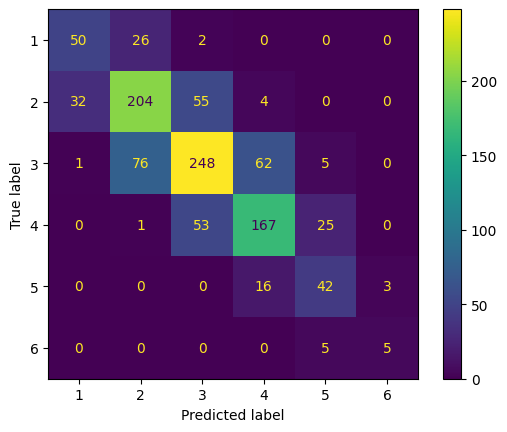

F1 score across fold: 0.6620122879657389
Cohen kappa score across fold: 0.8347271702784229

Fold_11 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.846375	valid's QWK: 0.835821
Early stopping, best iteration is:
[222]	train's QWK: 0.848206	valid's QWK: 0.837158
Evaluated only: QWK

Fold_11 LightGBM Model saved.

0:	learn: 0.9729383	test: 0.9739069	best: 0.9739069 (0)	total: 128ms	remaining: 2m 8s
100:	learn: 0.5094880	test: 0.5264876	best: 0.5264034 (97)	total: 11.8s	remaining: 1m 45s
200:	learn: 0.4872910	test: 0.5247671	best: 0.5245797 (196)	total: 22.9s	remaining: 1m 30s
bestTest = 0.5245796943
bestIteration = 196
Shrink model to first 197 iterations.

Fold_11 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:33:32] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07999	validation_0-QWK:0.45480	validation_1-rmse:1.08898	validation_1-QWK:0.43583
[0]	validation_0-rmse:1.07999	validation_0-QWK:0.45480	validation_1-rmse:1.08898	validation_1-QWK:0.43583
[1]	validation_0-rmse:0.97695	validation_0-QWK:0.46576	validation_1-rmse:0.99117	validation_1-QWK:0.45615
[2]	validation_0-rmse:0.88233	validation_0-QWK:0.49225	validation_1-rmse:0.90346	validation_1-QWK:0.47078
[3]	validation_0-rmse:0.80053	validation_0-QWK:0.55311	validation_1-rmse:0.82772	validation_1-QWK:0.52441
[4]	validation_0-rmse:0.73111	validation_0-QWK:0.62977	validation_1-rmse:0.76471	validation_1-QWK:0.58340
[5]	validation_0-rmse:0.67371	validation_0-QWK:0.67680	validation_1-rmse:0.71444	validation_1-QWK:0.63010
[6]	validation_0-rmse:0.62842	validation_0-QWK:0.71132	validation_1-rmse:0.67727	validation_1-QWK:0.67086
[7]	validation_0-rmse:0.58952	validation_0-QWK:0.76029	validation_1-rmse:0.64517	validation_1-QWK:0.71679
[8]	validation_0-rmse:0.55739	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:34:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not

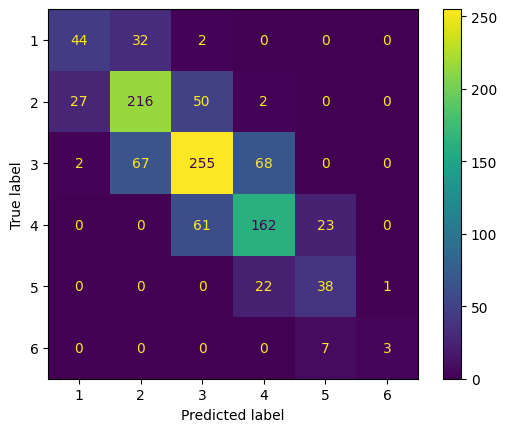

F1 score across fold: 0.6627165589556887
Cohen kappa score across fold: 0.837462022275022

Fold_12 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.846952	valid's QWK: 0.832825
Early stopping, best iteration is:
[142]	train's QWK: 0.840796	valid's QWK: 0.835735
Evaluated only: QWK

Fold_12 LightGBM Model saved.

0:	learn: 0.9731942	test: 0.9720187	best: 0.9720187 (0)	total: 129ms	remaining: 2m 8s
100:	learn: 0.5099144	test: 0.5251069	best: 0.5246998 (97)	total: 11.8s	remaining: 1m 44s
200:	learn: 0.4858284	test: 0.5255700	best: 0.5236207 (134)	total: 23.1s	remaining: 1m 31s
bestTest = 0.5236206804
bestIteration = 134
Shrink model to first 135 iterations.

Fold_12 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:14] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07986	validation_0-QWK:0.46317	validation_1-rmse:1.08579	validation_1-QWK:0.43964
[0]	validation_0-rmse:1.07986	validation_0-QWK:0.46317	validation_1-rmse:1.08579	validation_1-QWK:0.43964
[1]	validation_0-rmse:0.97657	validation_0-QWK:0.46796	validation_1-rmse:0.99177	validation_1-QWK:0.45238
[2]	validation_0-rmse:0.88200	validation_0-QWK:0.48443	validation_1-rmse:0.90668	validation_1-QWK:0.46503
[3]	validation_0-rmse:0.79983	validation_0-QWK:0.53515	validation_1-rmse:0.83423	validation_1-QWK:0.50293
[4]	validation_0-rmse:0.73050	validation_0-QWK:0.62890	validation_1-rmse:0.77382	validation_1-QWK:0.58782
[5]	validation_0-rmse:0.67292	validation_0-QWK:0.67427	validation_1-rmse:0.72471	validation_1-QWK:0.64363
[6]	validation_0-rmse:0.62768	validation_0-QWK:0.71337	validation_1-rmse:0.68831	validation_1-QWK:0.67740
[7]	validation_0-rmse:0.58886	validation_0-QWK:0.76309	validation_1-rmse:0.65644	validation_1-QWK:0.72484
[8]	validation_0-rmse:0.55724	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not

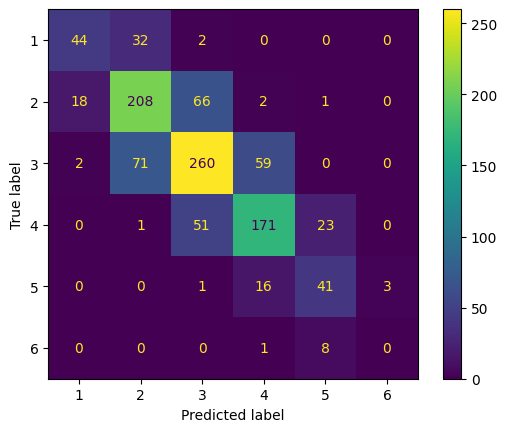

F1 score across fold: 0.6677577269596251
Cohen kappa score across fold: 0.830322871528092

Fold_13 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.848244	valid's QWK: 0.820734
Early stopping, best iteration is:
[160]	train's QWK: 0.844247	valid's QWK: 0.826241
Evaluated only: QWK

Fold_13 LightGBM Model saved.

0:	learn: 0.9724558	test: 0.9741484	best: 0.9741484 (0)	total: 134ms	remaining: 2m 14s
100:	learn: 0.5078938	test: 0.5474479	best: 0.5471237 (99)	total: 12s	remaining: 1m 46s
bestTest = 0.5467744824
bestIteration = 112
Shrink model to first 113 iterations.

Fold_13 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:36:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:36:59] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07965	validation_0-QWK:0.45770	validation_1-rmse:1.08459	validation_1-QWK:0.43101
[0]	validation_0-rmse:1.07965	validation_0-QWK:0.45770	validation_1-rmse:1.08459	validation_1-QWK:0.43101
[1]	validation_0-rmse:0.97663	validation_0-QWK:0.46537	validation_1-rmse:0.99147	validation_1-QWK:0.44249
[2]	validation_0-rmse:0.88194	validation_0-QWK:0.48190	validation_1-rmse:0.90778	validation_1-QWK:0.45868
[3]	validation_0-rmse:0.79973	validation_0-QWK:0.51932	validation_1-rmse:0.83390	validation_1-QWK:0.47640
[4]	validation_0-rmse:0.73003	validation_0-QWK:0.63317	validation_1-rmse:0.77479	validation_1-QWK:0.58786
[5]	validation_0-rmse:0.67267	validation_0-QWK:0.67649	validation_1-rmse:0.72726	validation_1-QWK:0.62606
[6]	validation_0-rmse:0.62724	validation_0-QWK:0.71417	validation_1-rmse:0.69086	validation_1-QWK:0.66812
[7]	validation_0-rmse:0.58799	validation_0-QWK:0.76090	validation_1-rmse:0.66101	validation_1-QWK:0.70462
[8]	validation_0-rmse:0.55627	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


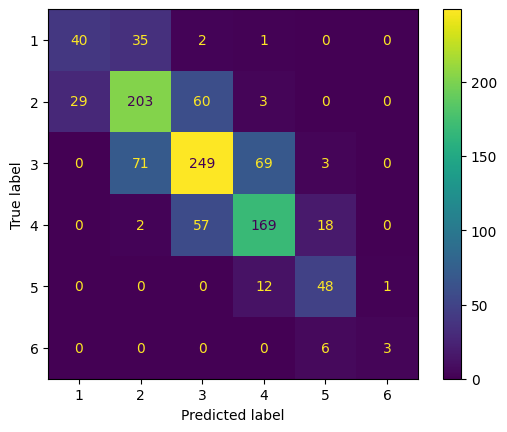

F1 score across fold: 0.6572257827902258
Cohen kappa score across fold: 0.8269249454871032

Fold_14 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.848936	valid's QWK: 0.82831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[215]	train's QWK: 0.850941	valid's QWK: 0.831002
Evaluated only: QWK

Fold_14 LightGBM Model saved.

0:	learn: 0.9723635	test: 0.9705941	best: 0.9705941 (0)	total: 135ms	remaining: 2m 15s
100:	learn: 0.5089827	test: 0.5356973	best: 0.5355415 (73)	total: 11.7s	remaining: 1m 44s
200:	learn: 0.4859223	test: 0.5357119	best: 0.5350253 (132)	total: 22.9s	remaining: 1m 31s
bestTest = 0.5350253416
bestIteration = 132
Shrink model to first 133 iterations.

Fold_14 CatBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:38:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:38:51] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07961	validation_0-QWK:0.45937	validation_1-rmse:1.08412	validation_1-QWK:0.44371
[0]	validation_0-rmse:1.07961	validation_0-QWK:0.45937	validation_1-rmse:1.08412	validation_1-QWK:0.44371
[1]	validation_0-rmse:0.97664	validation_0-QWK:0.46923	validation_1-rmse:0.98659	validation_1-QWK:0.45330
[2]	validation_0-rmse:0.88229	validation_0-QWK:0.48371	validation_1-rmse:0.89925	validation_1-QWK:0.46527
[3]	validation_0-rmse:0.80014	validation_0-QWK:0.54554	validation_1-rmse:0.82597	validation_1-QWK:0.52133
[4]	validation_0-rmse:0.73136	validation_0-QWK:0.62524	validation_1-rmse:0.76597	validation_1-QWK:0.58793
[5]	validation_0-rmse:0.67435	validation_0-QWK:0.67969	validation_1-rmse:0.71714	validation_1-QWK:0.64317
[6]	validation_0-rmse:0.62940	validation_0-QWK:0.71566	validation_1-rmse:0.67910	validation_1-QWK:0.68464
[7]	validation_0-rmse:0.59026	validation_0-QWK:0.75837	validation_1-rmse:0.64836	validation_1-QWK:0.73045
[8]	validation_0-rmse:0.55843	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:39:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:39:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:39:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not


Fold_14 XGBoost Model saved.



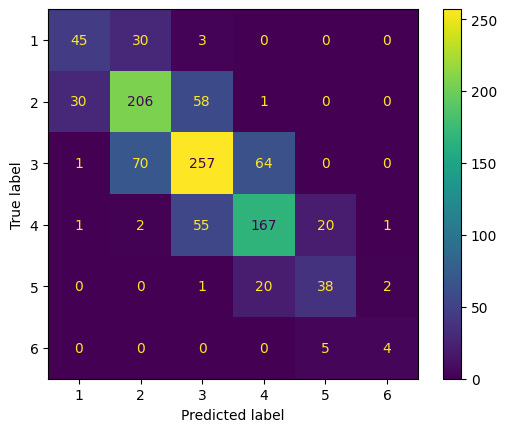

F1 score across fold: 0.6630558815523313
Cohen kappa score across fold: 0.830535304899251

Fold_15 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.847617	valid's QWK: 0.833975
Early stopping, best iteration is:
[132]	train's QWK: 0.839549	valid's QWK: 0.834906
Evaluated only: QWK

Fold_15 LightGBM Model saved.

0:	learn: 0.9727653	test: 0.9712246	best: 0.9712246 (0)	total: 130ms	remaining: 2m 9s
100:	learn: 0.5098304	test: 0.5269209	best: 0.5268918 (98)	total: 11.8s	remaining: 1m 44s
200:	learn: 0.4862193	test: 0.5246374	best: 0.5246374 (200)	total: 23.1s	remaining: 1m 31s
300:	learn: 0.4661828	test: 0.5235538	best: 0.5229859 (286)	total: 34.3s	remaining: 1m 19s
400:	learn: 0.4468735	test: 0.5229165	best: 0.5224750 (367)	total: 45.7s	remaining: 1m 8s
500:	learn: 0.4289853	test: 0.5211910	best: 0.5211910 (500)	total: 57s	remaining: 56.7s
bestTest = 0.52103

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:41:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:41:17] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07989	validation_0-QWK:0.46139	validation_1-rmse:1.08650	validation_1-QWK:0.44388
[0]	validation_0-rmse:1.07989	validation_0-QWK:0.46139	validation_1-rmse:1.08650	validation_1-QWK:0.44388
[1]	validation_0-rmse:0.97701	validation_0-QWK:0.46858	validation_1-rmse:0.99249	validation_1-QWK:0.44945
[2]	validation_0-rmse:0.88241	validation_0-QWK:0.48644	validation_1-rmse:0.90675	validation_1-QWK:0.45914
[3]	validation_0-rmse:0.80039	validation_0-QWK:0.54937	validation_1-rmse:0.83383	validation_1-QWK:0.51417
[4]	validation_0-rmse:0.73090	validation_0-QWK:0.63183	validation_1-rmse:0.77448	validation_1-QWK:0.58527
[5]	validation_0-rmse:0.67344	validation_0-QWK:0.68065	validation_1-rmse:0.72558	validation_1-QWK:0.63694
[6]	validation_0-rmse:0.62842	validation_0-QWK:0.71444	validation_1-rmse:0.68769	validation_1-QWK:0.67302
[7]	validation_0-rmse:0.58935	validation_0-QWK:0.76043	validation_1-rmse:0.65528	validation_1-QWK:0.71772
[8]	validation_0-rmse:0.55708	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:41:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


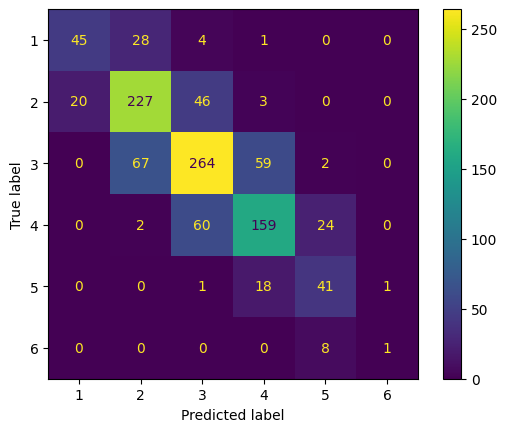

F1 score across fold: 0.6796906714306178
Cohen kappa score across fold: 0.8323087551855276

Fold_16 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[200]	train's QWK: 0.845712	valid's QWK: 0.840537
[400]	train's QWK: 0.862714	valid's QWK: 0.845789
Early stopping, best iteration is:
[363]	train's QWK: 0.859991	valid's QWK: 0.848112
Evaluated only: QWK

Fold_16 LightGBM Model saved.

0:	learn: 0.9728244	test: 0.9685513	best: 0.9685513 (0)	total: 128ms	remaining: 2m 8s
100:	learn: 0.5107069	test: 0.5071891	best: 0.5071825 (99)	total: 11.7s	remaining: 1m 44s
200:	learn: 0.4887503	test: 0.5059467	best: 0.5055729 (179)	total: 22.8s	remaining: 1m 30s
300:	learn: 0.4695160	test: 0.5052981	best: 0.5051539 (299)	total: 33.8s	remaining: 1m 18s
400:	learn: 0.4499557	test: 0.5046532	best: 0.5046532 (400)	total: 45.1s	remaining: 1m 7s
bestTest = 0.5046532395
bestIteration = 400
Shrink mode

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:54] WARNING: /workspace/src/l

[0]	validation_0-rmse:1.07926	validation_0-QWK:0.45551	validation_1-rmse:1.08543	validation_1-QWK:0.43395
[0]	validation_0-rmse:1.07926	validation_0-QWK:0.45551	validation_1-rmse:1.08543	validation_1-QWK:0.43395
[1]	validation_0-rmse:0.97657	validation_0-QWK:0.46747	validation_1-rmse:0.98556	validation_1-QWK:0.45204
[2]	validation_0-rmse:0.88187	validation_0-QWK:0.49684	validation_1-rmse:0.89530	validation_1-QWK:0.48645
[3]	validation_0-rmse:0.80008	validation_0-QWK:0.53801	validation_1-rmse:0.81968	validation_1-QWK:0.52777
[4]	validation_0-rmse:0.73069	validation_0-QWK:0.63041	validation_1-rmse:0.75710	validation_1-QWK:0.60759
[5]	validation_0-rmse:0.67375	validation_0-QWK:0.68084	validation_1-rmse:0.70673	validation_1-QWK:0.65046
[6]	validation_0-rmse:0.62849	validation_0-QWK:0.71514	validation_1-rmse:0.66879	validation_1-QWK:0.68736
[7]	validation_0-rmse:0.58922	validation_0-QWK:0.76016	validation_1-rmse:0.63635	validation_1-QWK:0.73542
[8]	validation_0-rmse:0.55751	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:44:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Fold_16 XGBoost Model saved.



/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:44:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


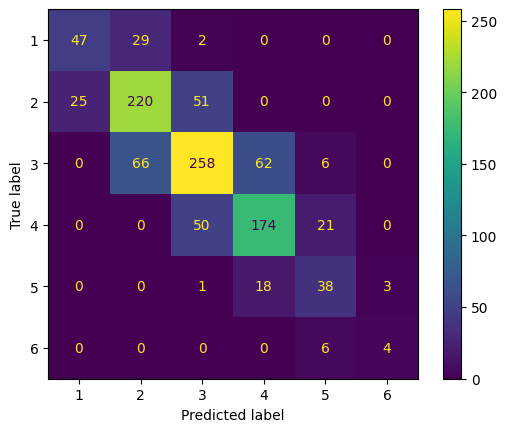

F1 score across fold: 0.6851811047475004
Cohen kappa score across fold: 0.845964701255145


In [17]:
LOAD = True # re-train
# Define the number of splits for cross-validation
n_splits = 16
models = []
device = 'GPU' if torch.cuda.is_available() else 'CPU'
print(f"Running on {device}")

if not LOAD:
    for i in range(n_splits):
        random_indices = np.random.choice(X.shape[0], size=5000, replace=False)
        random_test_X = X[random_indices, :]
        random_test_y = y_split[random_indices]
        lgb_predictor = lgb.Booster(model_file=f'kaggle/input/aes-lgbm/fold_{i+1}.txt')
        cat_model = CatBoostRegressor()
        cat_model.load_model(f'kaggle/input/aes-catboost/fold_{i+1}.cbm')
        xgb_regressor = xgb.Booster()
        xgb_regressor.load_model(f'kaggle/input/aes-xgboost/fold_{i+1}.bin')

        predictor = Predictor([lgb_predictor, cat_model, xgb_regressor])
        
        models.append(predictor)
        
        # # Make predictions on the test data for this fold
        #         # Make predictions on the test data for this fold
        predictions_fold = predictor.predict(random_test_X)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round().astype(int)
        
        # # Confusion Matrix for each fold
        # cm = confusion_matrix(random_test_y, predictions_fold, labels=[x for x in range(1,7)])
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=[x for x in range(1,7)])
        # disp.plot()
        # plt.show()
        
        # # Calculate and store the F1 score for this fold
        f1_fold = f1_score(random_test_y, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        # Calculate and store the Cohen's kappa score for this fold
        kappa_fold = cohen_kappa_score(random_test_y, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')
        gc.collect()
else:
    # Initialize StratifiedKFold with the specified number of splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    # Lists to store scores
    f1_scores = []
    kappa_scores = []
    models = []
    predictions = []
    callbacks = [log_evaluation(period=200), early_stopping(stopping_rounds=75,first_metric_only=True)]
    # Loop through each fold of the cross-validation
    i=1
    for train_index, test_index in skf.split(X, y_split):
        # Split the data into training and testing sets for this fold
        print('\nFold_{} Training ================================\n'.format(i))
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        # LGBM
        lgb_model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.05,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=42,
                    extra_trees=True,
                    class_weight='balanced',
                    # device= device,
                    verbosity = - 1)

        # Fit the model on the training data for this fold  
        lgb_predictor = lgb_model.fit(X_train_fold,
                              y_train_fold,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                              eval_metric=quadratic_weighted_kappa,
                              callbacks=callbacks
                             )

        lgb_predictor.booster_.save_model(f'kaggle/out/aes-lgbm/fold_{i}.txt')
        print('\nFold_{} LightGBM Model saved.\n'.format(i))
        cat_model = []
        # CAT
        cat_model = CatBoostRegressor(
            iterations=1000,
            learning_rate = 0.1,
            depth = 5,
            bootstrap_type='Bernoulli',
            subsample=0.8,
            l2_leaf_reg = 1,
            task_type = 'GPU',
            devices= '7:8',
            objective = 'RMSE',
            eval_metric = 'RMSE',
            loss_function="RMSE")
        train_pool = Pool(data = X_train_fold, label = y_train_fold)
        valid_pool = Pool(data = X_test_fold, label = y_test_fold)

        cat_model.fit(train_pool,
                    verbose=100,
                    eval_set=valid_pool,
                    early_stopping_rounds=75
                    )
        
        cat_model.save_model(f'kaggle/out/aes-catboost/fold_{i}.cbm')
        print('\nFold_{} CatBoost Model saved.\n'.format(i))
        
        # XGB
        
        xgb_regressor = xgb.XGBRegressor(
            objective = qwk_obj,
            metrics = 'None',
            learning_rate = 0.1,
            max_depth = 8,
            num_leaves = 10,
            colsample_bytree=0.5,
            reg_alpha = 1.0,
            reg_lambda = 0.1,
            n_estimators=1024,
            random_state=42,
            extra_trees=True,
            class_weight='balanced',
            tree_method="gpu_hist",
            gpu_id = 7
        )
    
        xgb_callbacks = [
            xgb.callback.EvaluationMonitor(period=300),
            xgb.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_regressor.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
            eval_metric=quadratic_weighted_kappa,
            callbacks=xgb_callbacks
        )
        xgb_regressor.save_model(f'kaggle/out/aes-xgboost/fold_{i}.bin')
        print('\nFold_{} XGBoost Model saved.\n'.format(i)) 
        
        # Ensemble
        
        predictor = Predictor([lgb_predictor, cat_model, xgb_regressor])
        
        models.append(predictor)
        # Make predictions on the test data for this fold
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        
        # Confusion Matrix for each fold
        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        
        # Calculate and store the F1 score for this fold
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        # Calculate and store the Cohen's kappa score for this fold
        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')
        i+=1
        gc.collect()


In [18]:
if not LOAD:
    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)
    print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
else:
    # Calculate the mean scores across all folds
    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)
    # Print the mean scores
    print(f'Ensemble Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Ensemble Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

Ensemble Mean F1 score across 16 folds: 0.6704909088884534
Ensemble Mean Cohen kappa score across 16 folds: 0.8336389717621387


# Inference

In [ ]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# TfidfVectorizer
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

/tmp/ipykernel_2119587/1122620497.py:20: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
/tmp/ipykernel_2119587/1122620497.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
/tmp/ipykernel_2119587/1122620497.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
/tmp/ipykernel_2119587/1122620497.py:24: MapWithou

Features number:  21899


,essay_id,paragraph_0_cnt,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,...,tfid_cnt_2160,tfid_cnt_2161,tfid_cnt_2162,tfid_cnt_2163,tfid_cnt_2164,tfid_cnt_2165,tfid_cnt_2166,tfid_cnt_2167,tfid_cnt_2168,tfid_cnt_2169
0,000d118,1,1,1,1,1,1,1,1,1,...,3,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,5,5,5,5,5,4,3,...,2,0,0,1,1,0,0,0,0,0
2,001ab80,4,4,4,4,4,4,4,4,4,...,1,0,2,0,0,0,0,0,0,0


# Submission

In [ ]:
# 定义非法字符的正则表达式
illegal_characters_pattern = re.compile(r'[\[\]<]')

# 筛选并输出具有非法字符的特征名称
illegal_features = [feature for feature in feature_names if illegal_characters_pattern.search(feature)]

# 输出非法特征名称
if illegal_features:
    print("具有非法字符的特征名称:")
    for feature in illegal_features:
        print(feature)
else:
    print("所有特征名称均合法")

所有特征名称均合法


In [ ]:
probabilities = []
for model in models:
    proba = model.predict(test_feats[feature_select]) + a
    probabilities.append(proba)
    
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)
predictions = np.round(predictions.clip(1, 6))

# Print the predictions
print(predictions)

[2. 3. 4.]


In [ ]:
submission = pd.read_csv("kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score'] = predictions
submission['score'] = submission['score'].astype(int)
submission.to_csv("submission.csv", index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4


# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ Ensemble ◀️</div>

In [ ]:
# # Load the data
# df1 = pd.read_csv('/kaggle/working/submission_1.csv')
# df2 = pd.read_csv('/kaggle/working/submission_2.csv')

# # Merging the dataframes on 'essay_id'
# df = pd.merge(left=df1, right=df2, on='essay_id', suffixes=('_1', '_2'))

# # Calculating the average score directly without apply()
# df['score'] = ((df['score_1'] + df['score_2']) / 2).round().astype(int)

# # Saving the desired columns to a new csv file
# df[['essay_id', 'score']].to_csv('submission.csv', index=False)